In [43]:
import osmnx as ox
import matplotlib.pyplot as plt
import json
import elevation as dem
import rasterio as rio
from rasterio.warp import Resampling

# Install gdal according to python version: GDAL-3.4.2-cp39-cp39-win_amd64.whl
# Install fiona according to python version: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
import geopandas as gpd
import pandas as pd
import numpy as np

# turn response caching off/on
# ox.settings.use_cache = False

In [129]:
roi = (49.81061769757704, 9.988233595428222)
roi = (51.8903, 10.41933)
gdf = ox.geometries_from_point(roi, dist=200, tags={'building': True})
with open('./roi.json', 'w', encoding='utf-8') as f:
    formatted_data = json.loads(gdf[['geometry', 'description', 'name']].to_json())
    json.dump(formatted_data, f, ensure_ascii=False, indent=4)

# gdf

In [107]:
roi = (51.8903, 10.41933) # Rammelsberg Coordinates (Lat, Lng)
fname = f"{os.getcwd()}/Rammelsberg-DEM.tif"
print(fname)

offset = 0.01 # is it 100m!
bbx = (roi[1]-offset, roi[0]-offset, roi[1]+offset, roi[0]+offset)
dem.clip(bounds=(bbx[0], bbx[1], bbx[2], bbx[3]), output=fname, product='SRTM1')
dem.clean() # clean up stale temporary files and fix the cache in the event of a server error
dem_data = rio.open(fname)

# resample data
upscale_factor = 30
data = dem_data.read(1,
    out_shape=( int(dem_data.height * upscale_factor), int(dem_data.width * upscale_factor)),
    out_dtype=np.double,
    resampling=Resampling.bilinear
)

# scale image transform
transform = dem_data.transform * dem_data.transform.scale(
    (dem_data.width / data.shape[-1]),
    (dem_data.height / data.shape[-2])
)


/home/ahmad/personal_ws/src/ROSExamples/script/Rammelsberg-DEM.tif


In [138]:
json_data = None
with open("./roi.json", "r") as f:
    json_data = json.load(f) # load as dictionary
    for feat in json_data['features']:
        for pt in feat['geometry']['coordinates'][0]:
            if len(pt) < 3:
                elev = data[rio.transform.rowcol(transform, pt[0], pt[1])] # lng, lat
                pt.append(elev)
            print(pt)

with open('./roi.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)

[10.4194923, 51.8905509, 332.0]
[10.4195133, 51.8905535, 333.0]
[10.4195576, 51.8905588, 334.0]
[10.419623, 51.8905666, 336.0]
[10.4200098, 51.8906128, 345.0]
[10.4200329, 51.8905392, 346.0]
[10.4202259, 51.8905623, 352.0]
[10.4202393, 51.8905194, 352.0]
[10.42055, 51.8905565, 361.0]
[10.4205732, 51.8904826, 361.0]
[10.4206119, 51.8903593, 362.0]
[10.420635, 51.8902857, 362.0]
[10.4203243, 51.8902486, 352.0]
[10.4203385, 51.8902033, 352.0]
[10.4203267, 51.8902019, 352.0]
[10.4203706, 51.8900617, 353.0]
[10.4199722, 51.890014, 338.0]
[10.4200135, 51.8898822, 340.0]
[10.4199582, 51.8898755, 339.0]
[10.419973, 51.8898284, 339.0]
[10.4199758, 51.8898193, 339.0]
[10.419984, 51.8897933, 339.0]
[10.4198617, 51.8897787, 337.0]
[10.4197493, 51.8897653, 334.0]
[10.4196888, 51.8897581, 333.0]
[10.419669, 51.8898212, 333.0]
[10.4194517, 51.8905461, 331.0]
[10.4194923, 51.8905509, 332.0]
[10.4193428, 51.8910365, 330.0]
[10.419271, 51.8912896, 328.0]
[10.4194709, 51.8913114, 331.0]
[10.4194602, 51.8

intersection(c1, c2): 68.44 m2
union(c1, c2): 88.39 m2
symmetric_difference(c1, c2): 19.95 m2
difference(c1, c2): 9.98 m2


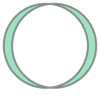

In [3]:
print(f"intersection(c1, c2): {c1.intersection(c2).area:0.2f} m2")  # common area between two circles
print(f"union(c1, c2): {c1.union(c2).area:0.2f} m2")  # total area
print(f"symmetric_difference(c1, c2): {c1.symmetric_difference(c2).area:0.2f} m2")  # total area except the overlap
print(f"difference(c1, c2): {c1.difference(c2).area:0.2f} m2")  # Subtract the c2 from c1 and result the remaining shape.
c1.symmetric_difference(c2)
# c1.difference(c2)  

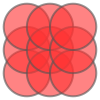

In [4]:
# Multipile polygon
lst = []
for x in range(0, 3):
    for y in range(0, 3):
        lst.append(Point(x, y).buffer(1))
        
mpg = MultiPolygon(lst)
# unary_union(mpg)  # Total scan area
mpg

<ipython-input-5-fb8a93335fe8>:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pg in mpg:


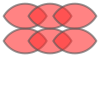

In [5]:
prev = None
ist = []
for pg in mpg:
    if prev is None:
        prev = pg
    else:
        # ist = pg.symmetric_difference(ist)
        ist.append(prev.intersection(pg))
        prev = pg

ist = MultiPolygon(ist)
# unary_union(ist)
ist

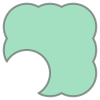

In [6]:
temp = unary_union(mpg)
temp1 = temp.difference(Point(0,0).buffer(1))
temp1

<AxesSubplot:>

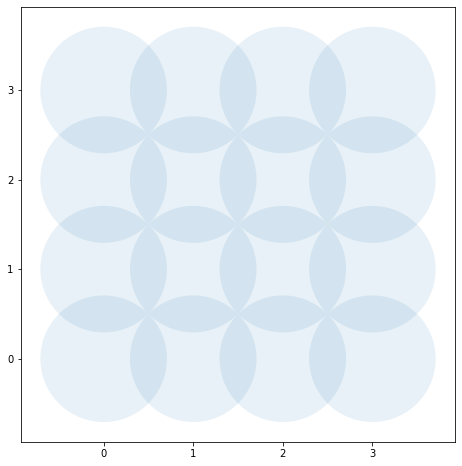

In [7]:
lst = []
for x in range(0, 4):
    for y in range(0, 4):
        lst.append(Point(x, y).buffer(0.707))     
gdf = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(lst)})
gdf.plot(alpha=0.1, figsize=(16, 8))

<ipython-input-8-7bccc999b33a>:13: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  merged_cells = unary_union([mpg[pos] for pos in idx.intersection(poly.bounds)])


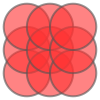

In [8]:
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(mpg.geoms):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)
    
# Loop through each Shapely polygon
lst = []
for poly in mpg.geoms:
    # Merge cells that have overlapping bounding boxes
    merged_cells = unary_union([mpg[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    lst.append(poly.intersection(merged_cells))
    
MultiPolygon(lst)

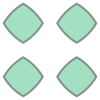

In [9]:
c00 = Point(0, 0).buffer(1)
c01 = Point(0, 1).buffer(1)
c02 = Point(0, 2).buffer(1)
c0 = c01.intersection(c00.union(c02)) 

c10 = Point(1, 0).buffer(1)
c11 = Point(1, 1).buffer(1)
c12 = Point(1, 2).buffer(1)
c1 = c11.intersection(c10.union(c12)) 

c20 = Point(2, 0).buffer(1)
c21 = Point(2, 1).buffer(1)
c22 = Point(2, 2).buffer(1)
c2 = c21.intersection(c20.union(c22)) 

c1.intersection(c0.union(c2))  # Region with 4 overlapping circles


In [10]:
from sklearn.neighbors import KDTree
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
# dist, idx = kdt.query(X[:1], k=3, return_distance=True) # Return distance and index of the three neighbours
idx, dist = kdt.query_radius(X[:1], r=5, return_distance=True, count_only=False) # Return distance and index within radius
print(dist)
print(idx)
# kdt.query_radius(X[:1], r=1, count_only=True, sort_results=True) # Return distance and index within radius


/home/ahmad/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[array([0.        , 1.        , 2.23606798, 2.82842712, 3.60555128,
        5.        ])                                               ]
[array([0, 1, 2, 3, 4, 5])]


In [11]:
radius = 1
centers = [[x,y] for x in range(0, 3, radius) for y in range(0, 3, radius)]
kdt = KDTree(centers, leaf_size=30, metric='euclidean')
idx, dist = kdt.query_radius([centers[0]], r=2*radius, count_only=False, return_distance=True, sort_results=True)
print(idx.tolist())
print(dist)

[array([0, 3, 1, 4, 2, 6])]
[array([0.        , 1.        , 1.        , 1.41421356, 2.        ,
        2.        ])                                               ]


In [12]:
centers[5]

[1, 2]